# Question 1

### Import necessary libraries

In [ ]:
import argparse
import data # import data.py
import math
import model # import model.py
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import torch
import torch.nn as nn
import torch.onnx
import torch.optim as optim

### Set necessary arguments

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# set up arguments
class Args:
  data = '/content/drive/MyDrive/CZ4045 - NLP/Assignment 2/2.1 fnn/data/wikitext-2'
  model = 'FNNModel'
  batch_size = 8
  bptt = 35             # back propogation through time
  context_size = 8      # 8 gram model
  clip = 0.25
  cuda = True           # use GPU
  dropout = 0.2         # dropout rate    
  emsize = 8            # embedding size
  epochs = 40
  nhid = 200            # number of hidden neurons
  nlayers = 2           # number of layers in neural network
  nhead = 2
  lr = 20               # learning rate
  log_interval = 200
  tied = True
  seed = 1111
  save = '/content/drive/MyDrive/CZ4045 - NLP/Assignment 2/2.1 fnn/model.pt'
  onnx_export = ''
  dry_run =  True

args = Args()

In [ ]:
torch.manual_seed(args.seed)
if torch.cuda.is_available():
    if not args.cuda:
        print("WARNING: You have a CUDA device, so you should probably run with --cuda")

device = torch.device("cuda" if args.cuda else "cpu")

### Load and Preprocess Data

In [ ]:
# taken from data.py
# tokenizes txt files in args.data
corpus = data.Corpus(args.data) 

In [ ]:
torch.set_printoptions(edgeitems=100)
print(corpus.train) 

tensor([    0,     1,     2,     3,     4,     1,     0,     0,     5,     6,
            2,     7,     8,     9,     3,    10,    11,     8,    12,    13,
           14,    15,     2,    16,    17,    18,     7,    19,    13,    20,
           21,    22,    23,     2,     3,     4,    24,    25,    13,    26,
           27,    28,    29,    30,    31,    32,    33,    34,    35,    36,
           37,    38,    39,    17,    40,    41,    15,    42,    43,    44,
           45,    43,    25,    13,    46,    26,    17,    47,    33,    43,
           17,     2,    48,    15,     9,    17,    49,    50,    16,    28,
           37,    51,    30,    52,    53,    23,    54,    55,    13,    17,
           56,    57,    58,    22,    17,    59,    33,    37,    60,    17,
         ...,    93,   622,    22,  5002,    78,  6656,  7628,    43,   293,
         1043,    15,  5277,  4726,   284, 23960,    26,   494,   489,   151,
        27535,   348,  4737,    43, 17444,    39,    17,  2532,  

### Batchify given data

In [ ]:
# Starting from sequential data, batchify arranges the dataset into columns.
# For instance, with the alphabet as the sequence and batch size 4, we'd get
# ┌ a g m s ┐
# │ b h n t │
# │ c i o u │
# │ d j p v │
# │ e k q w │
# └ f l r x ┘.
# These columns are treated as independent by the model, which means that the
# dependence of eg. 'g' on 'f' can not be learned, but allows more efficient
# batch processing.

In [ ]:
# bsz - batch size
def batchify(data, bsz):
    value = []
    data = data.numpy()
    for i, word in enumerate(data):
        if i + bsz >= len(data):
            # sentence boundary reached - ignore\\ sentence less than 3 words
            break
        # convert word to id
        value_inner = []
        for j in range(bsz+1):
            value_inner.append(data[i+j])
        value.append(value_inner)
    value = torch.LongTensor(value)
    return value.to(device)

In [ ]:
eval_batch_size = 8

# args.context_size = 8 since we require 8 gram model

train_data = batchify(corpus.train, args.context_size)
val_data = batchify(corpus.valid, eval_batch_size)
test_data = batchify(corpus.test, eval_batch_size)

In [ ]:
torch.set_printoptions(edgeitems=100)
print(train_data)

tensor([[    0,     1,     2,     3,     4,     1,     0,     0,     5],
        [    1,     2,     3,     4,     1,     0,     0,     5,     6],
        [    2,     3,     4,     1,     0,     0,     5,     6,     2],
        [    3,     4,     1,     0,     0,     5,     6,     2,     7],
        [    4,     1,     0,     0,     5,     6,     2,     7,     8],
        [    1,     0,     0,     5,     6,     2,     7,     8,     9],
        [    0,     0,     5,     6,     2,     7,     8,     9,     3],
        [    0,     5,     6,     2,     7,     8,     9,     3,    10],
        [    5,     6,     2,     7,     8,     9,     3,    10,    11],
        [    6,     2,     7,     8,     9,     3,    10,    11,     8],
        [    2,     7,     8,     9,     3,    10,    11,     8,    12],
        [    7,     8,     9,     3,    10,    11,     8,    12,    13],
        [    8,     9,     3,    10,    11,     8,    12,    13,    14],
        [    9,     3,    10,    11,     8,    12, 

### Functions to Load Data

In [ ]:
# get the real data and target for the train 
def get_batch(source, i):
    sequence_length = min(args.bptt, len(source) - 1 - i)

    # real data
    data = source[i:i+sequence_length, 0:args.context_size]

    # target
    target = source[i+1:i+1+sequence_length, args.context_size-1:args.context_size]
    target = target.narrow(1,0,1).contiguous().view(-1)
    return data, target

In [ ]:
data, target = get_batch(train_data, 0)

In [ ]:
print(data)

tensor([[ 0,  1,  2,  3,  4,  1,  0,  0],
        [ 1,  2,  3,  4,  1,  0,  0,  5],
        [ 2,  3,  4,  1,  0,  0,  5,  6],
        [ 3,  4,  1,  0,  0,  5,  6,  2],
        [ 4,  1,  0,  0,  5,  6,  2,  7],
        [ 1,  0,  0,  5,  6,  2,  7,  8],
        [ 0,  0,  5,  6,  2,  7,  8,  9],
        [ 0,  5,  6,  2,  7,  8,  9,  3],
        [ 5,  6,  2,  7,  8,  9,  3, 10],
        [ 6,  2,  7,  8,  9,  3, 10, 11],
        [ 2,  7,  8,  9,  3, 10, 11,  8],
        [ 7,  8,  9,  3, 10, 11,  8, 12],
        [ 8,  9,  3, 10, 11,  8, 12, 13],
        [ 9,  3, 10, 11,  8, 12, 13, 14],
        [ 3, 10, 11,  8, 12, 13, 14, 15],
        [10, 11,  8, 12, 13, 14, 15,  2],
        [11,  8, 12, 13, 14, 15,  2, 16],
        [ 8, 12, 13, 14, 15,  2, 16, 17],
        [12, 13, 14, 15,  2, 16, 17, 18],
        [13, 14, 15,  2, 16, 17, 18,  7],
        [14, 15,  2, 16, 17, 18,  7, 19],
        [15,  2, 16, 17, 18,  7, 19, 13],
        [ 2, 16, 17, 18,  7, 19, 13, 20],
        [16, 17, 18,  7, 19, 13, 2

In [ ]:
print(target)

tensor([ 5,  6,  2,  7,  8,  9,  3, 10, 11,  8, 12, 13, 14, 15,  2, 16, 17, 18,
         7, 19, 13, 20, 21, 22, 23,  2,  3,  4, 24, 25, 13, 26, 27, 28, 29],
       device='cuda:0')


### Build the model

#### FNN Model

In [ ]:
class FNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, context_size, h, tie_weights=False):
        super(FNNModel, self).__init__()
        # context_size - 8 since 8-gram model
        self.context_size = context_size
        self.embedding_dim = embedding_dim
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(context_size * embedding_dim, h)
        self.linear2 = nn.Linear(h, vocab_size, bias = False)         # Linear 2 is the decoder that returns a variable based on vocab size 

        # tie the weights together 
        if tie_weights:
          # h - number of hidden units
          if h != embedding_dim:
              raise ValueError('When using the tied flag, number of hidden units must be equal to embedding size')
          self.linear2.weight = self.embeddings.weight

        # initialising the weights 
        self.init_weights()

    # initialising the weights 
    def init_weights(self):
        initrange = 0.1
        nn.init.uniform_(self.embeddings.weight, -initrange, initrange)
        nn.init.zeros_(self.linear2.weight)
        nn.init.uniform_(self.linear2.weight, -initrange, initrange)


    # forward pass through network
    def forward(self, inputs):
        embeddings = self.embeddings(inputs).view((-1, self.context_size * self.embedding_dim))      # compute concatenation of all 8 words in the 8-gram model (x')
        out = torch.tanh(self.linear1(embeddings))                                                   # compute hidden layer value: tanh(W_1.x' + b)
        out = self.linear2(out)                                                                      # compute hidden layer output: W_2.h
        log_probability = torch.nn.functional.log_softmax(out, dim=1)                                # compute output (y) with softmax 
        return log_probability                                                                       # return log probabilities


### Helper functions  

In [ ]:
# Get accuracy from log probabilities
def get_accuracy_from_log_probability(log_probability, labels):
    probability = torch.exp(log_probability)
    predicted_label = torch.argmax(probability, dim=1)
    accuracy = (predicted_label == labels).float().mean()
    return accuracy



# Evaluate model on dev data
# criterion - loss function
def evaluate(model, criterion, data_source):
    model.eval()
    mean_accuracy, mean_loss = 0, 0
    count = 0

    with torch.no_grad():
        dev_start_time = time.time()
        for iteration, data_tensor in enumerate(range(0, data_source.size(0) - 1, args.bptt)):
            context_tensor, target_tensor = get_batch(data_source, data_tensor)
            context_tensor = context_tensor.to(device)
            target_tensor = target_tensor.to(device)
            log_probability = model(context_tensor)
            mean_loss += criterion(log_probability, target_tensor).item()
            mean_accuracy += get_accuracy_from_log_probability(log_probability, target_tensor)
            count += 1
            if iteration % 250 == 0: 
                print("Validation Iteration {} complete. Mean Loss: {}; Mean Acc:{}; Time taken (s): {}".format(iteration, mean_loss / count, mean_accuracy / count, (time.time()-dev_start_time)))
                dev_start_time = time.time()

    return mean_accuracy/count, mean_loss/count


### Training the model and evaluating on validation dataset

#### Set parameters

In [ ]:
# number of epochs
epochs = 6

# create model
number_of_tokens = len(corpus.dictionary)
model = FNNModel(number_of_tokens, args.emsize, args.context_size, args.nhid).to(device)

# ADAM optimizer
optimizer = optim.Adam(model.parameters(), lr = 2e-3)

# Using negative log-likelihood loss
loss_function = nn.NLLLoss()

#### TRAIN & SAVE MODEL

In [ ]:
my_logs_dict = []

In [ ]:
best_acc = 0
best_perplexity = 9999999999999999
best_model_path = None

# training set results 
loss_values = []
perplexity_values = []
accuracy_values = []

# val set results
val_loss = []
val_perplexity = []
val_acc = []

for epoch in range(epochs):
    start_time = time.time()
    running_loss = 0.0
    running_ppl = 0.0
    running_acc = 0.0

    print("\n--- Training model Epoch: {} ---".format(epoch+1))
    for it, data_tensor in enumerate(range(0, train_data.size(0) - 1, args.bptt)):
        context_tensor, target_tensor = get_batch(train_data, data_tensor)

        context_tensor = context_tensor.to(device)
        target_tensor = target_tensor.to(device)

        # zero out the gradients from the old instance
        model.zero_grad()

        # get log probabilities over next words
        log_probability = model(context_tensor)

        # calculate current accuracy
        acc = get_accuracy_from_log_probability(log_probability, target_tensor)

        # compute loss function
        loss = loss_function(log_probability, target_tensor)

        # backward pass and update gradient
        loss.backward()
        optimizer.step()
        
        # get total running loss and running perplexity
        running_loss = running_loss + loss.item()
        running_ppl = running_ppl + math.exp(loss.item())
        running_acc = running_acc + acc


        if it % 10000 == 0: 
            my_logs = "Training Iteration {} of epoch {} complete. Loss: {}; Acc:{}; Time taken (s): {}| Perplexity {:8.2f}".format(it, epoch, loss.item(), acc, (time.time()-start_time),  math.exp(loss.item()))
            print(my_logs)
            my_logs_dict.append({
            "Training Iteration": it,
            "Epoch": epoch,
            "Loss": loss.item(),
            "Accuracy": acc,
            "Time Taken": (time.time()-start_time),
            "Perplexity": math.exp(loss.item())
            }) 
            start_time = time.time()
    
    #Getting the total loss, perplexity and accuracy
    total_runs = math.floor((train_data.size(0) - 1)/(args.bptt))
    
    loss_values.append(running_loss / total_runs)
    perplexity_values.append(running_ppl / total_runs)
    accuracy_values.append(running_acc/ total_runs)

    #Evaluating the model on validation data set
    print("\n--- Evaluating model on validation data ---")
    dev_acc, dev_loss = evaluate(model, loss_function, val_data)
    dev_per = math.exp(dev_loss)
    print("Epoch {} complete! Validation Accuracy: {}; Validation Loss: {};  Validation Perplexity: {}".format(epoch, dev_acc, dev_loss, dev_per))
    val_acc.append(dev_acc)
    val_loss.append(dev_loss)
    val_perplexity.append(dev_per)

    # saving the model with lowest perplexity
    if dev_per < best_perplexity:
        print("Best validation perplexity improved from {} to {}, saving model...".format(best_perplexity, dev_per))
        best_perplexity = dev_per
        with open(args.save, 'wb') as f:
            torch.save(model, f)
        # set best model path
             
        best_model_path = 'best_model_{}.dat'.format(epoch)
        # saving best model
        torch.save(model.state_dict(), best_model_path)


--- Training model Epoch: 1 ---
Training Iteration 0 of epoch 0 complete. Loss: 8.787089347839355; Acc:0.11428571492433548; Time taken (s): 0.016617298126220703| Perplexity  6549.14
Training Iteration 10000 of epoch 0 complete. Loss: 5.943588733673096; Acc:0.2857142984867096; Time taken (s): 112.25534391403198| Perplexity   381.30
Training Iteration 20000 of epoch 0 complete. Loss: 7.243758678436279; Acc:0.1428571492433548; Time taken (s): 112.28676295280457| Perplexity  1399.34
Training Iteration 30000 of epoch 0 complete. Loss: 4.392612457275391; Acc:0.34285715222358704; Time taken (s): 112.35104632377625| Perplexity    80.85
Training Iteration 40000 of epoch 0 complete. Loss: 4.523105621337891; Acc:0.4571428596973419; Time taken (s): 112.34954619407654| Perplexity    92.12
Training Iteration 50000 of epoch 0 complete. Loss: 6.766234397888184; Acc:0.17142857611179352; Time taken (s): 112.30303502082825| Perplexity   868.04

--- Evaluating model on validation data ---
Validation Iter

In [ ]:
my_logs_dict

[{'Accuracy': tensor(1., device='cuda:0'),
  'Epoch': 0,
  'Loss': 10.100010871887207,
  'Perplexity': 24343.274080299783,
  'Time Taken': 0.016155004501342773,
  'Training Iteration': 0},
 {'Accuracy': tensor(0.1143, device='cuda:0'),
  'Epoch': 0,
  'Loss': 5.993350982666016,
  'Perplexity': 400.7552863987904,
  'Time Taken': 11.215450286865234,
  'Training Iteration': 1000},
 {'Accuracy': tensor(0.0286, device='cuda:0'),
  'Epoch': 0,
  'Loss': 7.013429164886475,
  'Perplexity': 1111.4593548356625,
  'Time Taken': 11.13805103302002,
  'Training Iteration': 2000},
 {'Accuracy': tensor(0.1714, device='cuda:0'),
  'Epoch': 0,
  'Loss': 6.003373622894287,
  'Perplexity': 404.7921084689567,
  'Time Taken': 11.101215362548828,
  'Training Iteration': 3000},
 {'Accuracy': tensor(0.0857, device='cuda:0'),
  'Epoch': 0,
  'Loss': 7.003429889678955,
  'Perplexity': 1100.4009470360481,
  'Time Taken': 11.138288736343384,
  'Training Iteration': 4000},
 {'Accuracy': tensor(0.1429, device='cuda:

In [ ]:
import csv
myheaders = ['Accuracy','Epoch','Loss', 'Perplexity', 'Time Taken', 'Training Iteration']

filename = 'my_model_logs.csv'
with open(filename, 'w', newline='') as myfile:
    writer = csv.DictWriter(myfile, fieldnames=myheaders)
    writer.writeheader()
    writer.writerows(my_logs_dict)

### Plot Results

Model Loss

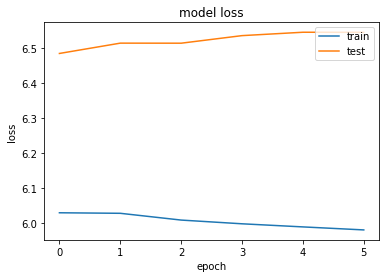

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(loss_values)
plt.plot(val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()
plt.savefig('/content/drive/MyDrive/CZ4045 - NLP/Assignment 2/2.1 fnn/results/loss.png')

Model Accuracy

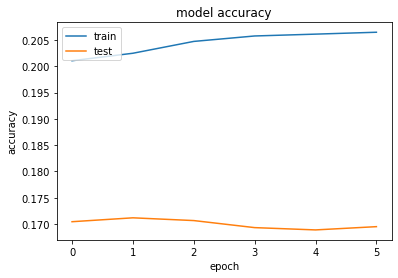

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(accuracy_values)
plt.plot(val_acc)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('/content/drive/MyDrive/CZ4045 - NLP/Assignment 2/2.1 fnn/results/accuracy.png')

Model Perplexity

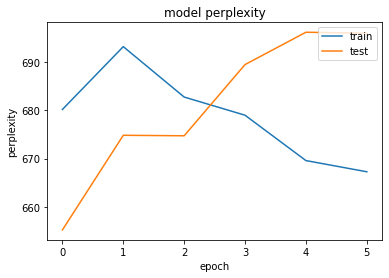

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(perplexity_values)
plt.plot(val_perplexity)
plt.title('model perplexity')
plt.ylabel('perplexity')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()
plt.savefig('/content/drive/MyDrive/CZ4045 - NLP/Assignment 2/2.1 fnn/results/perplexity.png')

### Evaluate trained model on test data

In [ ]:
# Load the best saved model.
with open(args.save, 'rb') as f:
    model = torch.load(f)

In [ ]:
# Run on test data.
test_accuracy, test_loss = evaluate(model, loss_function, test_data)
print('=' * 89)
print('| End of Training | test loss {:5.2f} | test perplexity {:8.2f} | test accuracy {:5.2f}'.format(
    test_loss, math.exp(test_loss), test_accuracy))
print('=' * 89)

Validation Iteration 0 complete. Mean Loss: 5.571355819702148; Mean Acc:0.11428571492433548; Time taken (s): 0.003813028335571289
Validation Iteration 250 complete. Mean Loss: 6.391323886544581; Mean Acc:0.17256690561771393; Time taken (s): 0.4067683219909668
Validation Iteration 500 complete. Mean Loss: 6.3698849316366655; Mean Acc:0.17319656908512115; Time taken (s): 0.3505725860595703
Validation Iteration 750 complete. Mean Loss: 6.386164481090642; Mean Acc:0.1727602481842041; Time taken (s): 0.3365449905395508
Validation Iteration 1000 complete. Mean Loss: 6.4132476710415744; Mean Acc:0.1721421480178833; Time taken (s): 0.3363676071166992
Validation Iteration 1250 complete. Mean Loss: 6.502263511303994; Mean Acc:0.17058341205120087; Time taken (s): 0.3360013961791992
Validation Iteration 1500 complete. Mean Loss: 6.434297327833284; Mean Acc:0.171409472823143; Time taken (s): 0.3359856605529785
Validation Iteration 1750 complete. Mean Loss: 6.39230285230056; Mean Acc:0.1718692183494

## Sharing the input and output layer embeddings 

In [ ]:
# number of epochs
epochs = 6

# create model
ntokens = len(corpus.dictionary)

# Model embedding size must be size
model = FNNModel(ntokens, args.emsize, args.context_size, args.emsize , True).to(device)

# ADAM optimizer
optimizer = optim.Adam(model.parameters(), lr = 2e-3)

# Using negative log-likelihood loss
loss_function = nn.NLLLoss()



#### TRAIN & SAVE MODEL

In [ ]:
my_logs_sharing_dict = []

In [ ]:
best_acc = 0
best_perplexity = 9999999999999999
best_model_path = None

# training set results 
loss_values=[]
perplexity_values=[]
accuracy_values=[]

#val set results
val_loss = []
val_perplexity=[]
val_acc=[]

for epoch in range(epochs):
    st = time.time()
    running_loss = 0.0
    running_ppl =0.0
    running_acc=0.0
    print("\n--- Training model Epoch: {} ---".format(epoch+1))
    for it, data_tensor in enumerate(range(0, train_data.size(0) - 1, args.bptt)):
        context_tensor, target_tensor= get_batch(train_data, data_tensor)

        context_tensor, target_tensor = context_tensor.to(device), target_tensor.to(device)

        # zero out the gradients from the old instance
        model.zero_grad()

        # get log probabilities over next words
        log_probs = model(context_tensor)

        # calculate current accuracy
        acc = get_accuracy_from_log_probability(log_probs, target_tensor)

        # compute loss function
        loss = loss_function(log_probs, target_tensor)

        # backward pass and update gradient
        loss.backward()
        optimizer.step()
        
        #getting thw total running loss and running perplexity
        running_loss = running_loss + loss.item()
        running_ppl = running_ppl + math.exp(loss.item())
        running_acc = running_acc+ acc


        if it % 10000 == 0: 
            print("Training Iteration {} of epoch {} complete. Loss: {}; Acc:{}; Time taken (s): {}| Perplexity {:8.2f}".format(it, epoch, loss.item(), acc, (time.time()-start_time),  math.exp(loss.item())))
            my_logs_sharing_dict.append({
            "Training Iteration": it,
            "Epoch": epoch,
            "Loss": loss.item(),
            "Accuracy": acc,
            "Time Taken": (time.time()-start_time),
            "Perplexity": math.exp(loss.item())
            }) 
            start_time = time.time()
    
    # Getting the total loss, perplexity and accuracy
    total_runs = math.floor((train_data.size(0) - 1)/(args.bptt))
    loss_values.append(running_loss / total_runs)
    perplexity_values.append(running_ppl / total_runs)
    accuracy_values.append(running_acc/ total_runs)

    # Evaluating the model on validation data set
    print("\n--- Evaluating model on dev data ---")
    dev_acc, dev_loss = evaluate(model, loss_function, val_data)
    dev_per = math.exp(dev_loss)
    print("Epoch {} complete! Validation Accuracy: {}; Validation Loss: {};  Validation Perplexity: {}".format(epoch, dev_acc, dev_loss, dev_per))
    val_acc.append(dev_acc)
    val_loss.append(dev_loss)
    val_perplexity.append(dev_per)

    # Saving the model with lowest perplexity
    if dev_per < best_perplexity:
        print("Best validation perplexity improved from {} to {}, saving model...".format(best_perplexity, dev_per))
        best_perplexity = dev_per
        with open(args.save, 'wb') as f:
            torch.save(model, f)
        # set best model path 
        best_model_path = 'best_model_{}.dat'.format(epoch)
        # saving best model
        torch.save(model.state_dict(), best_model_path)

--- Training model Epoch: 1 ---
Training Iteration 0 of epoch 0 complete. Loss: 5.556814193725586; Acc:0.1428571492433548; Time taken (s): 0.011534690856933594| Perplexity   259.00
Training Iteration 10000 of epoch 0 complete. Loss: 6.0280866622924805; Acc:0.17142857611179352; Time taken (s): 79.53499746322632| Perplexity   414.92
Training Iteration 20000 of epoch 0 complete. Loss: 7.343812942504883; Acc:0.17142857611179352; Time taken (s): 79.43594551086426| Perplexity  1546.60
Training Iteration 30000 of epoch 0 complete. Loss: 4.056315898895264; Acc:0.34285715222358704; Time taken (s): 79.37993860244751| Perplexity    57.76
Training Iteration 40000 of epoch 0 complete. Loss: 5.1330246925354; Acc:0.34285715222358704; Time taken (s): 79.35397529602051| Perplexity   169.53
Training Iteration 50000 of epoch 0 complete. Loss: 7.146264553070068; Acc:0.1428571492433548; Time taken (s): 79.42533326148987| Perplexity  1269.36

--- Evaluating model on dev data ---
Validation Iteration 0 compl

In [ ]:
my_logs_sharing_dict

[{'Accuracy': tensor(0.1429, device='cuda:0'),
  'Epoch': 0,
  'Loss': 5.556814193725586,
  'Perplexity': 258.99640821965187,
  'Time Taken': 1008.3207485675812,
  'Training Iteration': 0},
 {'Accuracy': tensor(0.1714, device='cuda:0'),
  'Epoch': 0,
  'Loss': 6.0280866622924805,
  'Perplexity': 414.92038659311584,
  'Time Taken': 1087.856703042984,
  'Training Iteration': 10000},
 {'Accuracy': tensor(0.1714, device='cuda:0'),
  'Epoch': 0,
  'Loss': 7.343812942504883,
  'Perplexity': 1546.5979744656236,
  'Time Taken': 1167.2940340042114,
  'Training Iteration': 20000},
 {'Accuracy': tensor(0.3429, device='cuda:0'),
  'Epoch': 0,
  'Loss': 4.056315898895264,
  'Perplexity': 57.7611208038598,
  'Time Taken': 1246.6755435466766,
  'Training Iteration': 30000},
 {'Accuracy': tensor(0.3429, device='cuda:0'),
  'Epoch': 0,
  'Loss': 5.1330246925354,
  'Perplexity': 169.52911678923624,
  'Time Taken': 1326.03062748909,
  'Training Iteration': 40000},
 {'Accuracy': tensor(0.1429, device='cud

In [ ]:
import csv
myheaders = ['Accuracy','Epoch','Loss', 'Perplexity', 'Time Taken', 'Training Iteration']

filename = 'my_model_logs_sharing.csv'
with open(filename, 'w', newline='') as myfile:
    writer = csv.DictWriter(myfile, fieldnames=myheaders)
    writer.writeheader()
    writer.writerows(my_logs_sharing_dict)

### Plot curves on test data

Model Loss

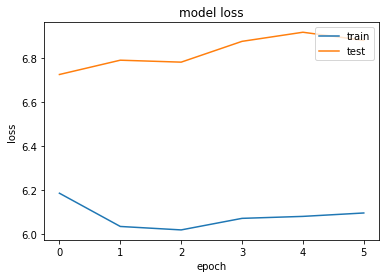

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(loss_values)
plt.plot(val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()
plt.savefig('/content/drive/MyDrive/CZ4045 - NLP/Assignment 2/2.1 fnn/results/shared_loss.png')

Model Accuracy

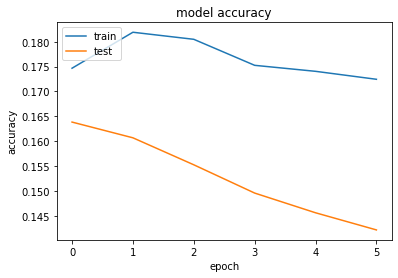

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(accuracy_values)
plt.plot(val_acc)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('/content/drive/MyDrive/CZ4045 - NLP/Assignment 2/2.1 fnn/results/shared_accuracy.png')

Model Perplexity

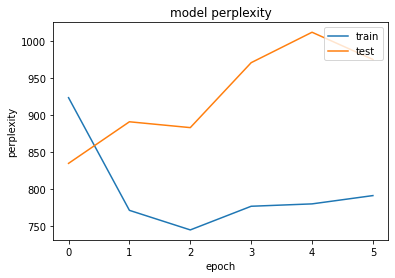

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(perplexity_values)
plt.plot(val_perplexity)
plt.title('model perplexity')
plt.ylabel('perplexity')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()
plt.savefig('/content/drive/MyDrive/CZ4045 - NLP/Assignment 2/2.1 fnn/results/shared_perplexity.png')

## Generate texts using the language model 

#### Set up parameters

In [ ]:
class Args:
  checkpoint = '/content/drive/MyDrive/CZ4045 - NLP/Assignment 2/Anusha/Without shared weights/not_sharing_best_model_0.dat'    # best model
  outf = '/content/drive/MyDrive/CZ4045 - NLP/Assignment 2/2.1 fnn/results/generated.txt'                           # output file
  words = 1000                                                                                                      # number of words to generate
  seed = 42
  log_interval = 100
  cuda = False
  temperature = 1.0

args = Args()

#### Set up Model

In [ ]:
# instantiate FNNModel
model = FNNModel(33278,200,8,200)
with open(args.checkpoint, 'rb') as f:
  # load model weights
   model.load_state_dict(torch.load(f,map_location=torch.device('cpu')))

model.eval()

FNNModel(
  (embeddings): Embedding(33278, 200)
  (linear1): Linear(in_features=1600, out_features=200, bias=True)
  (linear2): Linear(in_features=200, out_features=33278, bias=False)
)

#### Generate text

In [ ]:
ntokens = len(corpus.dictionary)

input = torch.randint(ntokens, (1, 8), dtype=torch.long).to('cpu')

with open(args.outf, 'w', encoding='utf-8') as outf:
    with torch.no_grad():  # no tracking history
        for i in range(args.words):
            output = model(input)
            word_weights = output.squeeze().div(args.temperature).exp().cpu()
            word_index = torch.multinomial(word_weights, 1)[0]
            input.fill_(word_index)

            word = corpus.dictionary.idx2word[word_index]

            outf.write(word + ('\n' if i % 20 == 19 else ' '))

            if i % args.log_interval == 0:
                print('| Generated {}/{} words'.format(i, args.words))


| Generated 0/1000 words
| Generated 100/1000 words
| Generated 200/1000 words
| Generated 300/1000 words
| Generated 400/1000 words
| Generated 500/1000 words
| Generated 600/1000 words
| Generated 700/1000 words
| Generated 800/1000 words
| Generated 900/1000 words


--------------------------------------------------------------------------------END---------------------------------------------------------------------------